In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math

import sys
sys.path.append('../scripts/code')

from pce import PCE
import distribution as distr
from test_functions_a import *

%matplotlib inline

In [2]:
seed = 0
np.random.seed(seed)

In [3]:
n_test = 10**6 #10**7 #!!!

In [4]:
sample_sizes = None

In [5]:
num_runs = 100 #30 #!!!

In [32]:
exp_name = 'experiments/test_risk_diff_basis_proj_11_'
save_all = True 

# Ishigami 

In [7]:
#  =======================================================================
# Define Ishigami 

dim = 3
def function(X):
    return ishigami(X)[:, np.newaxis]


lb = -1.0 * math.pi
ub = math.pi 

true_Sobol_indices = get_indices_ishigami(full=True) # 


#  ==================================================================
# Approximation setting

max_degrees = [4, 5, 6] #!!!


#  ==================================================================
# Experiment setting

start_power = 2 #2
end_power = 6 #!!#3.5 # training sample size = 10^end_power
num = 110 #6 #50 # 110

#  ==================================================================


function_name = 'Ishigami'
function_parameters = {}

In [33]:
exp_name += function_name

In [34]:
import os
import dill
print(dill.__version__)

db_name = exp_name+'.db'
if os.path.isfile(db_name):
    print('\n=============== Loading %s ======================\n'%db_name)
    dill.load_session(db_name) #!!!
    raise SystemExit("Workspace is loaded.")
else:
    print('Workspace %s not found'%db_name)

0.3.1.1
Workspace experiments/test_risk_diff_basis_proj_11_Ishigami.db not found


### Code

In [8]:
ranges = lb * np.ones((dim, 2))
ranges[:, 0] = ub


test_X = np.random.rand(n_test, dim)
test_X = (ranges[:, 1] - ranges[:, 0]) * test_X + ranges[:, 0]


test_Y = function(test_X)

true_SI_full = true_Sobol_indices['main']
true_TI_full = true_Sobol_indices['total']

groups = tuple(true_SI_full.keys())

S_full = [true_SI_full[g] for g in groups]
T_full = [true_TI_full[g] for g in groups]


In [9]:
indices_full_number = len(groups)
indices_full_number

7

In [10]:
L = np.max(np.abs(test_Y))

var_f = np.var(test_Y)

var_f, L

(13.856448886868698, 17.713165739816645)

In [12]:


def get_model_limit_mse(model, test_X, test_Y):
    
    test_size = int(len(test_X)*0.3)
    print('train size:', len(test_X)-test_size, ' + test size:', test_size)
    
    lambdas = np.array([0, 10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1])
    
    err = []
    for ls_lambda in lambdas:
        model.fit(test_X[test_size:], test_Y[test_size:], method='ls', ls_lambda=ls_lambda)
        err += [ model.validate(test_X[:test_size], test_Y[:test_size])['mse'] ]
        
    err = np.array(err)
    print('Errors:', err)
    print('lambda opt:', lambdas[err == np.min(err)])
    
    return np.min(err)



In [13]:
%%time


#N = model._basis_functions_number

if sample_sizes is None:
    sample_sizes = np.logspace(start_power, end_power, num=num, endpoint=True, base=10.0, dtype=np.int)
print('sample_sizes', sample_sizes)
max_n = max(sample_sizes)


err_S_list_Legendre = []
err_S_list_Trigonometric = []
N_list = []

mse_list_Legendre = [] 
mse_list_Trigonometric = []



method = 'projection' #'ls' #'projection' # #!!!
print('\nMethod:', method, '\n')


for max_degree in max_degrees:
    
    print('\n======== max_degree:', max_degree, '============\n')
    
    appr_SI_Legendre =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
    appr_TI_Legendre =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))

    appr_SI_Trigonometric  =  np.nan * np.ones((num_runs, len(sample_sizes), indices_full_number))
    appr_TI_Trigonometric  =  np.nan * np.ones((num_runs, len(sample_sizes),  indices_full_number))
    
    for j in range(num_runs):

        print('\nRun', j, '\n')

        all_X = (ranges[:, 1] - ranges[:, 0]) * np.random.rand(max_n, dim) + ranges[:, 0]

        #sigma = 2*L 
        all_Y = function(all_X)#  + sigma * np.random.randn(max_n, 1)

        for i, n in enumerate(sample_sizes):

            print(i, n, 'training samples')

            X = all_X[:n].copy()
            Y = all_Y[:n].copy()
            
            marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Legendre')]*dim)
            model_Legendre = PCE(marginals, {'max_degree':max_degree})
            
            marginals = distr.Marginals([distr.Uniform(lb, ub, poly_type='Trigonometric' )]*dim)
            model_Trigonometric = PCE(marginals, {'max_degree':max_degree})
        
            if method == 'projection' or model_Legendre._basis_functions_number <= n:
                
                model_Legendre.fit(X, Y, method=method)
                appr_SI_Legendre[j, i] = [model_Legendre.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI_Legendre[j, i] = [model_Legendre.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]
            
                model_Trigonometric.fit(X, Y, method=method)
                appr_SI_Trigonometric[j, i] = [model_Trigonometric.get_sobol_indices(ind_type='main', full=True)[g] for g in groups]
                appr_TI_Trigonometric[j, i] = [model_Trigonometric.get_sobol_indices(ind_type='total', full=True)[g] for g in groups]
            
            else:
                appr_SI_Legendre[j, i] = np.nan
                appr_TI_Legendre[j, i] = np.nan
                appr_SI_Trigonometric[j, i]  = np.nan
                appr_TI_Trigonometric[j, i]  = np.nan
                
                
    indices_errors = np.dstack((np.abs(appr_SI_Legendre - S_full)**2, np.abs(appr_TI_Legendre- T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S_list_Legendre += [max_indices_errors]
    
    
    indices_errors = np.dstack((np.abs(appr_SI_Trigonometric - S_full)**2, np.abs(appr_TI_Trigonometric- T_full)**2))
    mean_indices_errors = np.mean(indices_errors, axis=0)
    max_indices_errors = np.max(mean_indices_errors, axis=1)
    err_S_list_Trigonometric += [max_indices_errors]
    
    N_list += [model_Legendre._basis_functions_number]
    
    mse_list_Legendre += [get_model_limit_mse(model_Legendre, test_X, test_Y)]
    mse_list_Trigonometric += [get_model_limit_mse(model_Trigonometric, test_X, test_Y)]   


    

sample_sizes [    100     108     118     128     140     152     166     180     196
     213     232     253     275     299     326     355     386     420
     457     498     541     589     641     698     759     826     899
     979    1065    1159    1261    1372    1493    1625    1768    1924
    2094    2279    2480    2698    2936    3195    3477    3784    4117
    4481    4876    5306    5773    6282    6836    7439    8095    8809
    9586   10431   11351   12352   13441   14626   15916   17319   18846
   20508   22316   24284   26425   28755   31290   34049   37051   40318
   43873   47741   51951   56531   61516   66940   72842   79265   86254
   93859  102134  111140  120939  131603  143206  155833  169573  184524
  200794  218499  237764  258728  281540  306364  333377  362771  394757
  429563  467438  508653  553502  602305  655411  713199  776083  844511
  918973 1000000]

Method: projection 


======== max_degree: 4 ============


Run 0 

0 100 training samples
1

/home/ivan/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2125: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Errors: [2.02911013 2.02911009 2.02910976 2.02910664 2.02909683 2.03108609
 2.22343646]
lambda opt: [0.001]
train size: 700000  + test size: 300000
Errors: [0.27846064 0.27846063 0.27846058 0.27846028 0.27847997 0.28090732
 0.48945083]
lambda opt: [0.0001]

======== max_degree: 5 ============


Run 0 

0 100 training samples
1 108 training samples
2 118 training samples
3 128 training samples
4 140 training samples
5 152 training samples
6 166 training samples
7 180 training samples
8 196 training samples
9 213 training samples
10 232 training samples
11 253 training samples
12 275 training samples
13 299 training samples
14 326 training samples
15 355 training samples
16 386 training samples
17 420 training samples
18 457 training samples
19 498 training samples
20 541 training samples
21 589 training samples
22 641 training samples
23 698 training samples
24 759 training samples
25 826 training samples
26 899 training samples
27 979 training samples
28 1065 training samples
29 1159 t

In [14]:
appr_TI_Trigonometric

array([[[0.74627996, 0.83007951, 0.98573378, ..., 0.88197559,
         0.92879865, 1.        ],
        [0.74258228, 0.81593561, 0.98431392, ..., 0.88495378,
         0.91977833, 1.        ],
        [0.76212911, 0.79133479, 0.98521429, ..., 0.88379709,
         0.91959795, 1.        ],
        ...,
        [0.55271537, 0.44785209, 0.99999275, ..., 0.55281232,
         0.68479945, 1.        ],
        [0.5533571 , 0.44715683, 0.99999429, ..., 0.5534283 ,
         0.68443413, 1.        ],
        [0.55341941, 0.44707082, 0.99999173, ..., 0.55349126,
         0.68408105, 1.        ]],

       [[0.77280329, 0.82235935, 0.99228783, ..., 0.91725178,
         0.92238403, 1.        ],
        [0.75604827, 0.8246645 , 0.99000535, ..., 0.90892787,
         0.9323812 , 1.        ],
        [0.76265762, 0.81812129, 0.98619548, ..., 0.91502756,
         0.92820317, 1.        ],
        ...,
        [0.55603723, 0.44456638, 0.99999196, ..., 0.55615428,
         0.68321325, 1.        ],
        [0.5

In [15]:
err_S_list_Legendre

[array([0.2018003 , 0.19421249, 0.18662968, 0.17821396, 0.17043673,
        0.15841294, 0.15180931, 0.14511027, 0.13623355, 0.12725604,
        0.11705999, 0.11117556, 0.10328815, 0.09697328, 0.08890175,
        0.0822376 , 0.07783063, 0.07258722, 0.06774367, 0.06138121,
        0.05483733, 0.05114719, 0.04595166, 0.04099219, 0.03675927,
        0.03291742, 0.03017255, 0.02721294, 0.0254462 , 0.02410159,
        0.02312972, 0.02213895, 0.02122736, 0.01980968, 0.0186656 ,
        0.01815071, 0.01684549, 0.01638447, 0.01557534, 0.01491064,
        0.01406099, 0.01346534, 0.01304374, 0.01281462, 0.01231713,
        0.01200186, 0.0117836 , 0.01160577, 0.01138246, 0.01122083,
        0.01093567, 0.01057442, 0.01048779, 0.01024133, 0.01006314,
        0.00987898, 0.0096736 , 0.00948584, 0.00931258, 0.00911312,
        0.0089568 , 0.00892719, 0.00880354, 0.00871435, 0.00864853,
        0.00858079, 0.00855263, 0.00848419, 0.00841139, 0.00842496,
        0.00834156, 0.00833205, 0.00834627, 0.00

In [16]:
str(model_Trigonometric)

"PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric), Uniform(a=-3.141592653589793, b=3.141592653589793, Trigonometric)]), basis_truncation={'max_degree': 6})"

In [17]:
str(model_Legendre)

"PCE(marginals=Marginals([Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre), Uniform(a=-3.141592653589793, b=3.141592653589793, Legendre)]), basis_truncation={'max_degree': 6})"

In [18]:
err_S_list_Trigonometric

[array([0.155035  , 0.14750148, 0.14005163, 0.13116119, 0.1236638 ,
        0.11400157, 0.10823158, 0.10246978, 0.09290882, 0.08649758,
        0.07754283, 0.07128858, 0.06436829, 0.06008113, 0.05422824,
        0.04801581, 0.044022  , 0.04016337, 0.0363759 , 0.03294945,
        0.02832861, 0.02509207, 0.02179692, 0.01945154, 0.01674938,
        0.0143517 , 0.01214646, 0.01081128, 0.00925046, 0.00825569,
        0.00737355, 0.00640432, 0.0055801 , 0.00477652, 0.00408344,
        0.00358509, 0.00314688, 0.00266144, 0.00239214, 0.00223126,
        0.00197824, 0.00177621, 0.00162904, 0.0015099 , 0.00136929,
        0.00118655, 0.00103976, 0.00095212, 0.00087249, 0.00079775,
        0.00073682, 0.00069368, 0.00063068, 0.00059725, 0.00056534,
        0.00051436, 0.0005078 , 0.00049411, 0.00050286, 0.00049595,
        0.00045909, 0.00043557, 0.00042981, 0.00040784, 0.00039247,
        0.00038789, 0.00035772, 0.00035612, 0.00034552, 0.00033759,
        0.00033486, 0.00032661, 0.00031717, 0.00

In [36]:

file_save = exp_name +'.npz' #!!!
np.savez(file_save, max_degrees, sample_sizes, 
         err_S_list_Legendre, mse_list_Legendre, 
         err_S_list_Trigonometric, mse_list_Trigonometric,
         L, N_list, var_f, num_runs,
         function_name, function_parameters) #!!!

In [20]:
# file_save = 'risk_diff_basis_Sobol2_5' +'.npz' #!!!

# loaded = np.load(file_save, allow_pickle=True)
# data = [loaded[key] for key in loaded]
# max_degrees, sample_sizes, err_S_list_Legendre, mse_list_Legendre, err_S_list_Trigonometric, mse_list_Trigonometric,L, N_list, var_f, num_runs, function_name, function_parameters = data

In [21]:
mse_list_Legendre 

[2.0290968283252204, 1.9630065507478414, 0.11760308796080764]

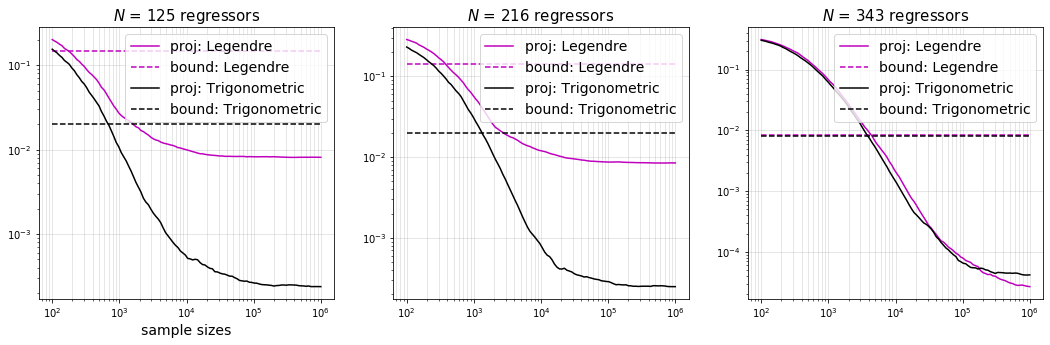

In [37]:
n_sig = len(err_S_list_Trigonometric) #len(sigma_list)

marker= "" # None #'o'
linestyle=None#'--'

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500

fontsize = 15


plt.figure(figsize=(18, 5))

for l in range(n_sig):
    

    plt.subplot(1, n_sig, l+1)
    
    plt.title('$N$ = {} regressors'.format(N_list[l]), fontsize=fontsize)
    
    plt.loglog(sample_sizes[ind], err_S_list_Legendre[l][ind], label='%s: Legendre'%method[:4],
               linestyle=linestyle, marker=marker, color='m')
    
    plt.loglog(sample_sizes[ind],  [mse_list_Legendre[l] / var_f]*sum(ind), label='bound: Legendre',
               linestyle='--', marker=None, color='m')
        
        
    plt.loglog(sample_sizes[ind], err_S_list_Trigonometric[l][ind], label='%s: Trigonometric'%method[:4],
               linestyle=linestyle, marker=marker, color='k')
    
    
    plt.loglog(sample_sizes[ind],  [mse_list_Trigonometric[l] / var_f]*sum(ind), 
               label='bound: Trigonometric',
               linestyle='--', marker=None, color='k')

    
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
        

    #k = (L**2+sigma_list[l]**2) * N / var_f
    #plt.loglog(sample_sizes[ind], k/sample_sizes[ind], label='bound ($\sigma$)',linestyle='--', color='k')
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
        #plt.ylabel('Empirical risk of SI', fontsize=14)
    plt.legend(loc='upper right', fontsize=fontsize-1) #  'best'
    
if save_all:
    fname = exp_name+'_3.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

In [40]:
from matplotlib.patches import Ellipse

def add_annotation(text,textcolor, xy, xytext):
    col = 'wheat'#,'papayawhip'#'blanchedalmond' #'oldlace'#'beige'#'ivory'#
    el = Ellipse((0, 0), 10, 20, facecolor=col, alpha=0.5)
    ann = ax.annotate(text,
                  xy=xy, xycoords='data',
                  xytext=xytext, textcoords='offset points',
                  size=fontsize,
                  color=textcolor,
                  bbox=dict(boxstyle="round",
                            color=col, #'w', # ,
                            ec=col), # 'wheat'
                  arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                  color=col, #'w', # 
                                  ec=col, # 'k',
                                  patchA=None,
                                  patchB=el,
                                  relpos=(0.2, 0.8),
                                  connectionstyle="arc3,rad=-0.1"),
                   clip_on=True)



===================== projection ===========================



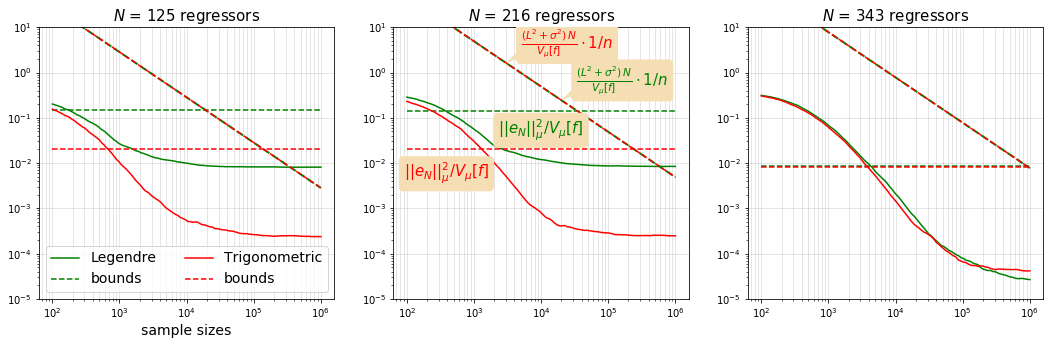

In [65]:
n_sig = len(err_S_list_Trigonometric) #len(sigma_list)

print('\n===================== %s ===========================\n'%method)

marker= "" # None #'o'
linestyle=None#'--'

sample_sizes = np.array(sample_sizes) # , dtype=float
ind = sample_sizes > 0 # sample_sizes > 500

fontsize = 15




plt.figure(figsize=(18, 5))

for l in range(n_sig):

    ax = plt.subplot(1, n_sig, l+1)
    
    plt.title('$N$ = {} regressors'.format(N_list[l]), fontsize=fontsize)
    
    plt.loglog(sample_sizes[ind], err_S_list_Legendre[l][ind], label='Legendre',
               linestyle=linestyle, marker=marker, color='g')
    
    plt.loglog(sample_sizes[ind],  [mse_list_Legendre[l] / var_f]*sum(ind), label='bounds',
               linestyle='--', marker=None, color='g')
        
        
    plt.loglog(sample_sizes[ind], err_S_list_Trigonometric[l][ind], label='Trigonometric',
               linestyle=linestyle, marker=marker, color='r')
    
    k = L**2 * N_list[l] / var_f
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind],linestyle='--', color='g', linewidth=2) # label='bound ($L, \sigma$)'
    plt.loglog(sample_sizes[ind], k/sample_sizes[ind],linestyle='--', color='r')
    
    
    
    plt.loglog(sample_sizes[ind],  [mse_list_Trigonometric[l] / var_f]*sum(ind), 
               label='bounds',
               linestyle='--', marker=None, color='r')
        
    plt.grid(b=True, which='both', color='#999999', axis='x',linestyle='-', alpha=0.3)
    plt.grid(b=True, which='major', color='#999999', axis='y',linestyle='-', alpha=0.3)
        
    plt.gca().set_ylim(bottom=10**-5)
    plt.gca().set_ylim(top=10)
    
    
    if l == 0:
        plt.xlabel('sample sizes', fontsize=14)
        plt.legend(loc='lower center', fontsize=fontsize-1, ncol=2) #  'best', 'upper right'

    if l == 2:
        pass
        
        
        
        
    if l == 1:
#         add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]$', textcolor='g', 
#                        xy=(10**3 , mse_list_Legendre[l] / var_f), xytext=(15, 15)) # r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$'
#         add_annotation(text=r'$||e_N||^2_{\mu} / V_{\mu}[f]}$', textcolor='r', 
#                         xy=(3*10**3 , mse_list_Trigonometric[l] / var_f), xytext=(15, 15)) # r'$\frac{||e_N||^2_{\mu} }{V_{\mu}[f]}$'
        
        props = dict(boxstyle='round', facecolor='wheat', ec='wheat')
        ax.text(2.3*10**3, 10**-1, r'$||e_N||^2_{\mu} / V_{\mu}[f]$',fontsize=fontsize,
                verticalalignment='top', bbox=props, color='g')
        ax.text(90, 1.1 * 10**-2, r'$||e_N||^2_{\mu} / V_{\mu}[f]}$',fontsize=fontsize,
                verticalalignment='top', bbox=props, color='r')



        add_annotation(text=r'$\frac{(L^2+\sigma^2) \, N }{V_{\mu}[f]} \cdot  1/n$', textcolor='r', 
                       xy=(3*10**3, k/(3*10**3)), xytext=(15, 15))
        add_annotation(text=r'$\frac{(L^2+\sigma^2) \, N }{V_{\mu}[f]} \cdot  1/n$', textcolor='g', 
                       xy=(2*10**4, k/(2*10**4)), xytext=(15, 15))
        
        

    
if save_all:
    fname = exp_name+'_7.png'
    plt.savefig(fname, dpi=300, bbox_inches='tight', pad_inches=0.05)

In [24]:
# (L**2+sigma_list[l]**2) * N / var_f

In [25]:
# np.log10(N)

In [35]:
import dill, os
print(dill.__version__)

if os.path.isfile(db_name):
    print('Not saved: file %s already exists'%db_name)
    
else:
    if save_all:
        dill.dump_session(db_name)
        print(db_name, 'is saved')

0.3.1.1
experiments/test_risk_diff_basis_proj_11_Ishigami.db is saved
